# Mask R-CNN Demo

A quick intro to using the pre-trained model to detect and segment objects.

In [1]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
# IMAGE_DIR = os.path.join(ROOT_DIR, "images")
IMAGE_DIR = os.path.join(ROOT_DIR, "../cvpr/input/test")

Using TensorFlow backend.


## Configurations

We'll be using a model trained on the MS-COCO dataset. The configurations of this model are in the ```CocoConfig``` class in ```coco.py```.

For inferencing, modify the configurations a bit to fit the task. To do so, sub-class the ```CocoConfig``` class and override the attributes you need to change.

In [2]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Create Model and Load Trained Weights

In [3]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


## Class Names

The model classifies objects and returns class IDs, which are integer value that identify each class. Some datasets assign integer values to their classes and some don't. For example, in the MS-COCO dataset, the 'person' class is 1 and 'teddy bear' is 88. The IDs are often sequential, but not always. The COCO dataset, for example, has classes associated with class IDs 70 and 72, but not 71.

To improve consistency, and to support training on data from multiple sources at the same time, our ```Dataset``` class assigns it's own sequential integer IDs to each class. For example, if you load the COCO dataset using our ```Dataset``` class, the 'person' class would get class ID = 1 (just like COCO) and the 'teddy bear' class is 78 (different from COCO). Keep that in mind when mapping class IDs to class names.

To get the list of class names, you'd load the dataset and then use the ```class_names``` property like this.
```
# Load COCO dataset
dataset = coco.CocoDataset()
dataset.load_coco(COCO_DIR, "train")
dataset.prepare()

# Print class names
print(dataset.class_names)
```

We don't want to require you to download the COCO dataset just to run this demo, so we're including the list of class names below. The index of the class name in the list represent its ID (first class is 0, second is 1, third is 2, ...etc.)

In [4]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

# need: car, motorcycle, bicycle, pedestrian, truck, bus, and tricycle


# 3: car -> 33
# 4: motorcycle -> 34
# 2: bicycle -> 35
# 1: person -> 36
# 8: truck -> 38
# 6: bus -> 39
# tricycle -> none

## Run Object Detection

In [5]:
def id_transfer(model_id):
    id_dict = {
        3: 33,
        4: 34,
        2: 35,
        1: 36,
        8: 38,
        6: 39
    }
    return id_dict[model_id] if model_id in id_dict else None


In [6]:
''' slower version
def get_pcount_encode(mask, i):
    pix_i = 0
    tmp_i = None
    pix_c = 0
    encode_s = ''
    total_pix = 0
    en_dict = dict()
    for col_i in range(len(mask)):
#         if True in mask[col_i]:
            for row_i in range(len(mask[col_i])):
                if mask[col_i][row_i][i]:
                    pix_c += 1
                    if not tmp_i:
                        tmp_i = pix_i
                else:
                    if not tmp_i is None:
                        encode_s += str(tmp_i) + ' ' + str(pix_c) + '|'
    #                     en_dict[str(tmp_i)] = pix_c
                    total_pix += pix_c
                    tmp_i = None
                    pix_c = 0
                pix_i += 1
            
#     encode_str = ''
#     for key, val in en_dict.items():
#         encode_str += str(key) + ' ' + str(val) + '|'
    
#     total = 0
#     for i in en_dict:
#         total += int(en_dict[str(i)])
#     print(total, total_pix)
    return total_pix, encode_s
    
'''

" slower version\ndef get_pcount_encode(mask, i):\n    pix_i = 0\n    tmp_i = None\n    pix_c = 0\n    encode_s = ''\n    total_pix = 0\n    en_dict = dict()\n    for col_i in range(len(mask)):\n#         if True in mask[col_i]:\n            for row_i in range(len(mask[col_i])):\n                if mask[col_i][row_i][i]:\n                    pix_c += 1\n                    if not tmp_i:\n                        tmp_i = pix_i\n                else:\n                    if not tmp_i is None:\n                        encode_s += str(tmp_i) + ' ' + str(pix_c) + '|'\n    #                     en_dict[str(tmp_i)] = pix_c\n                    total_pix += pix_c\n                    tmp_i = None\n                    pix_c = 0\n                pix_i += 1\n            \n#     encode_str = ''\n#     for key, val in en_dict.items():\n#         encode_str += str(key) + ' ' + str(val) + '|'\n    \n#     total = 0\n#     for i in en_dict:\n#         total += int(en_dict[str(i)])\n#     print(total, t

In [7]:
def get_pcount_encode(image, x_min, y_min, shape):
    pcount = 0
    encoded = ""
    
    for y in range(len(image)):
        start, end, flag = 0, 0, True
        for e in range(len(image[y])):
            if image[y][e]:
                if flag:
                    start, flag = e, False
                end = e
        if start != 0:
            encoded += "{} {}|".format(((x_min + y) * shape[1]) + y_min + start, end - start + 1)
            pcount += end - start + 1
    return pcount, encoded

In [8]:
def get_pcount_encode(mask, class_num):
    dic = {}
    for col_i in range(len(mask)):
        for row_i in range(len)
    
    
#     for col_i in range(len(mask)):

tmp = get_pcount_encode(i, 4)
print(len(tmp))
        

SyntaxError: invalid syntax (<ipython-input-8-0fec9f562725>, line 4)

In [ ]:
# file_names = next(os.walk(IMAGE_DIR))[2]
# # print(file_names)
# # for file_name in file_names:
# #     print(file_name)
# print(len(file_names))
# for i in range(len(file_names)):
#     print(f"finish {i}/1916")
# file_names = next(os.walk(IMAGE_DIR))[2]

In [13]:
# f1 = random.choice(file_names)
# f2 = random.choice(file_names)
# f3 = random.choice(file_names)
# file_lst = [f1]
file_names = next(os.walk(IMAGE_DIR))[2]
data = []
for idx in range(len(file_names)):
    img_i = file_names[idx]
    img = skimage.io.imread(os.path.join(IMAGE_DIR, img_i))
    res = model.detect([img], verbose=1)
    print(f'detect {idx} over!')
    r = res[0]
#     print('result')
#     print(r)
#     print(r['class_ids'])
    shape = r['masks'].shape
    for i in range(len(r['class_ids'])):
        label_id = id_transfer(r['class_ids'][i])
        if label_id is not None:
            obj = dict()
            obj['ImageId'] = img_i.split('.')[0]
#             print(f'create img id')
            obj['LabelId'] = label_id
#             print(f'create label id')
            obj['Confidence'] = r['scores'][i]
#             print(f'create confidence')
            
            
            x_min, y_min, x_max, y_max = r['rois'][i]
            tmp = r['masks'][x_min:x_max, y_min:y_max, i]
            pcount, encode = get_pcount_encode(tmp, x_min, y_min, shape)
            
            ''' slower version
            pcount, encode = get_pcount_encode(r['masks'], i)
            '''
            
#             print(f'create pixelcount & encode')
            obj['PixelCount'] = pcount
            obj['EncodedPixels'] = encode
            data.append(obj)
    print(f"finish {idx}/1916")
# print(data)

Processing 1 images
image                    shape: (2710, 3384, 3)       min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 0 over!
finish 0/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:   10.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1 over!
finish 1/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images           

Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 19 over!
finish 19/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 20 over!
finish 20/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images       

detect 37 over!
finish 37/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 38 over!
finish 38/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 39 over!
finish 39/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    2.00000  max:  255.00

detect 56 over!
finish 56/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 57 over!
finish 57/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 58 over!
finish 58/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00

detect 75 over!
finish 75/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 76 over!
finish 76/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 77 over!
finish 77/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00

detect 94 over!
finish 94/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 95 over!
finish 95/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 96 over!
finish 96/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00

detect 113 over!
finish 113/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 114 over!
finish 114/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 115 over!
finish 115/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  

detect 132 over!
finish 132/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 133 over!
finish 133/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 134 over!
finish 134/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  

detect 151 over!
finish 151/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 152 over!
finish 152/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 153 over!
finish 153/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  

detect 170 over!
finish 170/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 171 over!
finish 171/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 172 over!
finish 172/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  

detect 189 over!
finish 189/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 190 over!
finish 190/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 191 over!
finish 191/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  

detect 208 over!
finish 208/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 209 over!
finish 209/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 210 over!
finish 210/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    5.00000  max:  

detect 227 over!
finish 227/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 228 over!
finish 228/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 229 over!
finish 229/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  

detect 246 over!
finish 246/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 247 over!
finish 247/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 248 over!
finish 248/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    3.00000  max:  

detect 265 over!
finish 265/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 266 over!
finish 266/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 267 over!
finish 267/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  

detect 284 over!
finish 284/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 285 over!
finish 285/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 286 over!
finish 286/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  

detect 303 over!
finish 303/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 304 over!
finish 304/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 305 over!
finish 305/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  

detect 322 over!
finish 322/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 323 over!
finish 323/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 324 over!
finish 324/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    3.00000  max:  

detect 341 over!
finish 341/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 342 over!
finish 342/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 343 over!
finish 343/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  

detect 360 over!
finish 360/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 361 over!
finish 361/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 362 over!
finish 362/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    2.00000  max:  

detect 379 over!
finish 379/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 380 over!
finish 380/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 381 over!
finish 381/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    4.00000  max:  

detect 398 over!
finish 398/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 399 over!
finish 399/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 400 over!
finish 400/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  

detect 417 over!
finish 417/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 418 over!
finish 418/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 419 over!
finish 419/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  

detect 436 over!
finish 436/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 437 over!
finish 437/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 438 over!
finish 438/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  

detect 455 over!
finish 455/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 456 over!
finish 456/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 457 over!
finish 457/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  

detect 474 over!
finish 474/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 475 over!
finish 475/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 476 over!
finish 476/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  

detect 493 over!
finish 493/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 494 over!
finish 494/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 495 over!
finish 495/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  

detect 512 over!
finish 512/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 513 over!
finish 513/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 514 over!
finish 514/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  

detect 531 over!
finish 531/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 532 over!
finish 532/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 533 over!
finish 533/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  

detect 550 over!
finish 550/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 551 over!
finish 551/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 552 over!
finish 552/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  

detect 569 over!
finish 569/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 570 over!
finish 570/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 571 over!
finish 571/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  

detect 588 over!
finish 588/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 589 over!
finish 589/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 590 over!
finish 590/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  

detect 607 over!
finish 607/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 608 over!
finish 608/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 609 over!
finish 609/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  

detect 626 over!
finish 626/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 627 over!
finish 627/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 628 over!
finish 628/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    4.00000  max:  

detect 645 over!
finish 645/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 646 over!
finish 646/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 647 over!
finish 647/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  

detect 664 over!
finish 664/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 665 over!
finish 665/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 666 over!
finish 666/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  

detect 683 over!
finish 683/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 684 over!
finish 684/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 685 over!
finish 685/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  

detect 702 over!
finish 702/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 703 over!
finish 703/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 704 over!
finish 704/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  

detect 721 over!
finish 721/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 722 over!
finish 722/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 723 over!
finish 723/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  

detect 740 over!
finish 740/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 741 over!
finish 741/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 742 over!
finish 742/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  

detect 759 over!
finish 759/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 760 over!
finish 760/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 761 over!
finish 761/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    1.00000  max:  

detect 778 over!
finish 778/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 779 over!
finish 779/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 780 over!
finish 780/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  

detect 797 over!
finish 797/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 798 over!
finish 798/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:   11.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 799 over!
finish 799/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    3.00000  max:  

detect 816 over!
finish 816/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 817 over!
finish 817/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 818 over!
finish 818/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  

detect 835 over!
finish 835/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 836 over!
finish 836/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 837 over!
finish 837/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  

detect 854 over!
finish 854/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 855 over!
finish 855/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 856 over!
finish 856/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    8.00000  max:  

detect 873 over!
finish 873/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 874 over!
finish 874/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 875 over!
finish 875/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  

detect 892 over!
finish 892/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 893 over!
finish 893/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 894 over!
finish 894/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  

detect 911 over!
finish 911/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 912 over!
finish 912/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 913 over!
finish 913/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  

detect 930 over!
finish 930/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 931 over!
finish 931/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 932 over!
finish 932/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  

detect 949 over!
finish 949/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 950 over!
finish 950/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 951 over!
finish 951/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  

detect 968 over!
finish 968/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 969 over!
finish 969/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 970 over!
finish 970/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    8.00000  max:  

detect 987 over!
finish 987/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 988 over!
finish 988/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 989 over!
finish 989/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  

detect 1006 over!
finish 1006/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1007 over!
finish 1007/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1008 over!
finish 1008/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  

detect 1025 over!
finish 1025/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1026 over!
finish 1026/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1027 over!
finish 1027/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  

detect 1044 over!
finish 1044/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1045 over!
finish 1045/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1046 over!
finish 1046/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  

detect 1063 over!
finish 1063/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1064 over!
finish 1064/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1065 over!
finish 1065/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  

detect 1082 over!
finish 1082/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1083 over!
finish 1083/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1084 over!
finish 1084/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  

detect 1101 over!
finish 1101/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1102 over!
finish 1102/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1103 over!
finish 1103/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  

detect 1120 over!
finish 1120/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1121 over!
finish 1121/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1122 over!
finish 1122/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    2.00000  

detect 1139 over!
finish 1139/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1140 over!
finish 1140/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1141 over!
finish 1141/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    5.00000  

detect 1158 over!
finish 1158/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1159 over!
finish 1159/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1160 over!
finish 1160/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  

detect 1177 over!
finish 1177/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1178 over!
finish 1178/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1179 over!
finish 1179/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    3.00000  

detect 1196 over!
finish 1196/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1197 over!
finish 1197/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1198 over!
finish 1198/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  

detect 1215 over!
finish 1215/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1216 over!
finish 1216/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1217 over!
finish 1217/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    2.00000  

detect 1234 over!
finish 1234/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1235 over!
finish 1235/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1236 over!
finish 1236/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  

detect 1253 over!
finish 1253/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1254 over!
finish 1254/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1255 over!
finish 1255/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  

detect 1272 over!
finish 1272/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1273 over!
finish 1273/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1274 over!
finish 1274/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  

detect 1291 over!
finish 1291/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1292 over!
finish 1292/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1293 over!
finish 1293/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    2.00000  

detect 1310 over!
finish 1310/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1311 over!
finish 1311/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1312 over!
finish 1312/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    2.00000  

detect 1329 over!
finish 1329/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1330 over!
finish 1330/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1331 over!
finish 1331/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  

detect 1348 over!
finish 1348/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1349 over!
finish 1349/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1350 over!
finish 1350/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    6.00000  

detect 1367 over!
finish 1367/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1368 over!
finish 1368/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1369 over!
finish 1369/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  

detect 1386 over!
finish 1386/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1387 over!
finish 1387/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1388 over!
finish 1388/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    3.00000  

detect 1405 over!
finish 1405/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1406 over!
finish 1406/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1407 over!
finish 1407/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  

detect 1424 over!
finish 1424/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1425 over!
finish 1425/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1426 over!
finish 1426/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    3.00000  

detect 1443 over!
finish 1443/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1444 over!
finish 1444/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1445 over!
finish 1445/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  

detect 1462 over!
finish 1462/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1463 over!
finish 1463/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1464 over!
finish 1464/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:   11.00000  

detect 1481 over!
finish 1481/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1482 over!
finish 1482/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1483 over!
finish 1483/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    9.00000  

detect 1500 over!
finish 1500/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1501 over!
finish 1501/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1502 over!
finish 1502/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  

detect 1519 over!
finish 1519/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1520 over!
finish 1520/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1521 over!
finish 1521/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  

detect 1538 over!
finish 1538/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1539 over!
finish 1539/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1540 over!
finish 1540/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  

detect 1557 over!
finish 1557/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1558 over!
finish 1558/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1559 over!
finish 1559/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  

detect 1576 over!
finish 1576/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1577 over!
finish 1577/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1578 over!
finish 1578/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    1.00000  

detect 1595 over!
finish 1595/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1596 over!
finish 1596/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1597 over!
finish 1597/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    1.00000  

detect 1614 over!
finish 1614/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1615 over!
finish 1615/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1616 over!
finish 1616/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    1.00000  

detect 1633 over!
finish 1633/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1634 over!
finish 1634/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1635 over!
finish 1635/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    1.00000  

detect 1652 over!
finish 1652/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1653 over!
finish 1653/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1654 over!
finish 1654/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  

detect 1671 over!
finish 1671/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1672 over!
finish 1672/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1673 over!
finish 1673/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    3.00000  

detect 1690 over!
finish 1690/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1691 over!
finish 1691/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1692 over!
finish 1692/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  

detect 1709 over!
finish 1709/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1710 over!
finish 1710/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1711 over!
finish 1711/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  

detect 1728 over!
finish 1728/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1729 over!
finish 1729/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1730 over!
finish 1730/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    1.00000  

detect 1747 over!
finish 1747/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1748 over!
finish 1748/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1749 over!
finish 1749/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  

detect 1766 over!
finish 1766/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1767 over!
finish 1767/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1768 over!
finish 1768/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    1.00000  

detect 1785 over!
finish 1785/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1786 over!
finish 1786/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1787 over!
finish 1787/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  

detect 1804 over!
finish 1804/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1805 over!
finish 1805/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1806 over!
finish 1806/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  

detect 1823 over!
finish 1823/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1824 over!
finish 1824/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1825 over!
finish 1825/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  

detect 1842 over!
finish 1842/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1843 over!
finish 1843/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1844 over!
finish 1844/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  

detect 1861 over!
finish 1861/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1862 over!
finish 1862/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1863 over!
finish 1863/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  

detect 1880 over!
finish 1880/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1881 over!
finish 1881/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1882 over!
finish 1882/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  

detect 1899 over!
finish 1899/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    9.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1900 over!
finish 1900/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detect 1901 over!
finish 1901/1916
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  

In [14]:
res_df = pd.DataFrame(data)

In [15]:
res_df.to_csv('submission_v4.csv', index=False)

Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


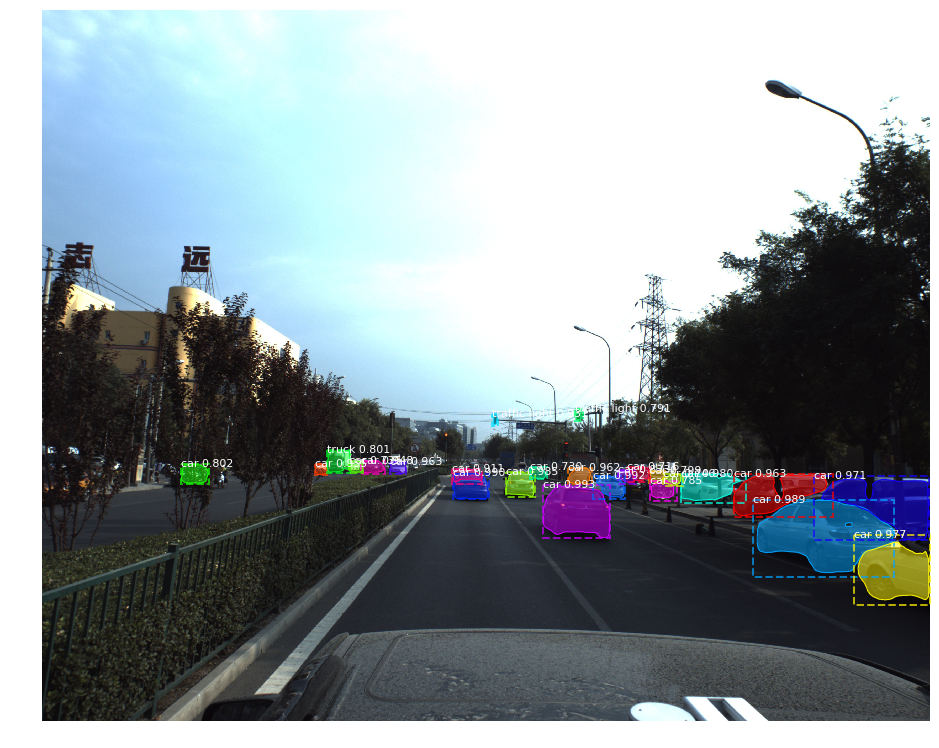

In [10]:
# Load a random image from the images folder
file_names = next(os.walk(IMAGE_DIR))[2]
# print(file_names)
file_name = random.choice(file_names)



image = skimage.io.imread(os.path.join(IMAGE_DIR, file_name))
# image = skimage.io.imread('./test/39-141202145P2.jpg')
# Run detection
results = model.detect([image], verbose=1)

# print('\n\nresults:\n', results, '\n\n')

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

In [15]:
for i in range(len(r['masks'])):
    print(True in r['masks'][i])

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [7]:
def get_pcount(mask, i):
    pixs = 0
    for col_i in range(len(mask)):
        for row_i in range(len(mask[col_i])):
            if mask[col_i][row_i][i]:
                pixs += 1
    print(pixs)

In [8]:
def get_encode(mask, i):
    pix_i = 0
    tmp_i = None
    pix_c = 0
    encode = ''
    en_dict = dict()
    for col_i in range(len(mask)):
        for row_i in range(len(mask[col_i])):
            if mask[col_i][row_i][i]:
                pix_c += 1
                if not tmp_i:
                    tmp_i = pix_i
            else:
                if not tmp_i is None:
                    en_dict[str(tmp_i)] = pix_c
                tmp_i = None
                pix_c = 0
            pix_i += 1
    print(en_dict)
    
    total = 0
    for i in en_dict:
        total += int(en_dict[str(i)])
    print(total)

In [45]:
print(results[0]['class_ids'])
print(len(results[0]['class_ids']))
# for i in np.nditer(results[0]['class_ids'], flags=['f_index']):
for i in range(len(results[0]['class_ids'])):
    print(i)
    print(results[0]['class_ids'][i], '\n')

[3 3 3 3 3]
5
0
3 

1
3 

2
3 

3
3 

4
3 



In [20]:
print('ImageId: ', file_name.split('.')[0])
i = 0
print('LabelId: ', id_transfer(results[0]['class_ids'][i]))
print('Confidence', results[0]['scores'][i])
get_pcount(results[0]['masks'], 0)

ImageId:  ef0802e9dd6478620ff26a038f664bd7
LabelId:  33
Confidence 0.9922152
124460


In [10]:
test = {'a': 1, 'b': 22}
for key, val in test.items():
    print(key, val)

a 1
b 22
